Note on variable names:

* SC = skycalc
* AP = astroplan
* RC = Riley Clarke (me)

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from config import *

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, FK5
from astropy.io import fits

from astroplan import Observer

In [42]:
from utils import celest_to_pa
from utils import pa

In [3]:
data = pd.read_csv('../skycalc_data.csv', skiprows=1)
data.head()

,Observatory,UT Date,RA,Dec,Local Time,UT,LMST,HA,secz,PA
0,Kitt Peak,2021-03-21,14 15 40,19 10 56,0:00:00,7:00:00,11:30:00,-2 47,1.297,-62.6
1,Kitt Peak,2021-03-21,14 15 40,19 10 56,6:00:00,13:00:00,17:31:00,3 14,1.42,63.5
2,Kitt Peak,2021-03-21,2 41 39,89 15 51,0:00:00,7:00:00,11:30:00,8 20,1.91,54.7
3,Kitt Peak,2021-03-21,2 41 39,89 15 51,6:00:00,13:00:00,17:31:00,-9 39,1.918,-35.0
4,Kitt Peak,2021-09-23,14 15 40,19 10 56,0:00:00,7:00:00,23:43:00,9 26,(down),36.3


In [4]:
#Convert HA strings to floats
for i, ha in enumerate(data.HA):
    if int(data['HA'].iloc[i].split()[0]) >= 0:
        data['HA'].iloc[i] = int(data['HA'].iloc[i].split()[0]) + (int(data['HA'].iloc[i].split()[1]) / 60.)
    else:
        data['HA'].iloc[i] = int(data['HA'].iloc[i].split()[0]) - (int(data['HA'].iloc[i].split()[1]) / 60.)

In [5]:
#Create numeric LMST column
LMSTnum = np.zeros(len(data))

for i, lmst in enumerate(data.LMST):
   LMSTnum[i] = pd.to_datetime(lmst).hour + pd.to_datetime(lmst).minute / 60 + pd.to_datetime(lmst).second / 3600

data['LMSTnum'] = LMSTnum

In [6]:
#Create numeric RA & Dec column
RAnum = np.zeros(len(data))
Decnum = np.zeros(len(data))

for i, ra in enumerate(data.RA):
    RAnum[i] = int(ra.split()[0]) + int(ra.split()[1]) / 60 + int(ra.split()[2]) / 3600

for i, dec in enumerate(data.Dec):
    Decnum[i] = int(dec.split()[0]) + int(dec.split()[1]) / 60 + int(dec.split()[2]) / 3600
    
data['RAnum'] = RAnum
data['Decnum'] = Decnum

In [7]:
data.head()

,Observatory,UT Date,RA,Dec,Local Time,UT,LMST,HA,secz,PA,LMSTnum,RAnum,Decnum
0,Kitt Peak,2021-03-21,14 15 40,19 10 56,0:00:00,7:00:00,11:30:00,-2.783333,1.297,-62.6,11.500000,14.261111,19.182222
1,Kitt Peak,2021-03-21,14 15 40,19 10 56,6:00:00,13:00:00,17:31:00,3.233333,1.42,63.5,17.516667,14.261111,19.182222
2,Kitt Peak,2021-03-21,2 41 39,89 15 51,0:00:00,7:00:00,11:30:00,8.333333,1.91,54.7,11.500000,2.694167,89.264167
3,Kitt Peak,2021-03-21,2 41 39,89 15 51,6:00:00,13:00:00,17:31:00,-9.65,1.918,-35.0,17.516667,2.694167,89.264167
4,Kitt Peak,2021-09-23,14 15 40,19 10 56,0:00:00,7:00:00,23:43:00,9.433333,(down),36.3,23.716667,14.261111,19.182222


In [8]:
dPA_RC_SC = np.zeros(len(data))
dHA_RC_SC = np.zeros(len(data))
pa_RC_arr = np.zeros(len(data))
lmst_RC_arr = np.zeros(len(data))
lmst_SC_arr = np.zeros(len(data))

for i in range(len(data)):
    obs = data.iloc[i]
    print(obs)
    print(' ')
    #Direct skycalc outputs
    loc = EarthLocation.of_site(obs['Observatory'])
    coord = SkyCoord(ra = obs['RA'], dec = obs['Dec'], unit = (u.hourangle, u.deg))
    time = Time(obs['UT Date'] + 'T' + obs['UT'], scale='ut1')
    
    obsLMST = obs['LMSTnum']

    #Outputs derived from skycalc with my code
    lmst_RC = time.sidereal_time('mean', longitude=loc.lon.value)
    ha_RC = obsLMST - coord.ra.hour
    pa_RC = pa(ha_RC, loc.lat.value, coord.dec.value)

    pa_RC_arr[i] = pa_RC
    lmst_RC_arr[i] = lmst_RC.hms[0] + lmst_RC.hms[1] / 60 + lmst_RC.hms[2] / 3600
    lmst_SC_arr[i] = obsLMST
    dPA_RC_SC[i] = np.abs(pa_RC - obs['PA'])
    dHA_RC_SC[i] = np.abs(ha_RC - obs['HA'])

    print('RA = {}'.format(coord.ra.hour))

    #PA
    print('My code says: PA = {}'.format(pa_RC))
    print('Skycalc says: PA = {}'.format(obs['PA']))
    print(' ')

    #LMST
    print('My code says: LMST = {0:.0f}:{1:.0f}:{2:.3f}'.format(lmst_RC.hms[0],lmst_RC.hms[1],lmst_RC.hms[2]))
    print('Skycalc says: LMST = {}'.format(obs['LMST']))
    print(' ')

    #HA
    print('My code says: HA = {}'.format(ha_RC))
    print('Skycalc says: HA = {}'.format(obs['HA']))
    print('-------------------------')

data['PA_RC'] = pa_RC_arr

Observatory     Kitt Peak
UT Date        2021-03-21
RA               14 15 40
Dec              19 10 56
Local Time        0:00:00
UT                7:00:00
LMST             11:30:00
HA              -2.783333
secz                1.297
PA                  -62.6
LMSTnum              11.5
RAnum           14.261111
Decnum          19.182222
Name: 0, dtype: object
 
RA = 14.261111111111111
My code says: PA = -62.59812888209926
Skycalc says: PA = -62.6
 
My code says: LMST = 11:29:41.369
Skycalc says: LMST = 11:30:00
 
My code says: HA = -2.761111111111111
Skycalc says: HA = -2.783333333333333
-------------------------
Observatory     Kitt Peak
UT Date        2021-03-21
RA               14 15 40
Dec              19 10 56
Local Time        6:00:00
UT               13:00:00
LMST             17:31:00
HA               3.233333
secz                 1.42
PA                   63.5
LMSTnum         17.516667
RAnum           14.261111
Decnum          19.182222
Name: 1, dtype: object
 
RA = 14.261111111

In [9]:
#Is skycalc rounding the LMST to the nearest minute?
((lmst_RC_arr * 60).round() - (lmst_SC_arr * 60))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Yes!

In [10]:
data['dPA_RC_SC'] = np.abs(data['PA'] - data['PA_RC'])

In [11]:
secz_ordered = data.sort_values(by='secz', ascending=True)
secz_ordered['secz'] = pd.to_numeric(secz_ordered['secz'], errors='coerce')
secz_ordered

,Observatory,UT Date,RA,Dec,Local Time,UT,LMST,HA,secz,PA,LMSTnum,RAnum,Decnum,PA_RC,dPA_RC_SC
23,Cerro Tololo,2021-09-23,14 15 40,19 10 56,0:00:00,4:00:00,23:26:00,9.15,NaN,114.5,23.433333,14.261111,19.182222,114.427223,0.072777
46,Apache Point,2021-03-21,20 41 26,45 16 49,0:00:00,7:00:00,11:53:00,-8.816667,NaN,-38.4,11.883333,20.690556,45.280278,-38.592927,0.192927
15,Palomar,2021-09-23,14 15 40,19 10 56,6:00:00,13:00:00,5:23:00,-8.9,NaN,-40.6,5.383333,14.261111,19.182222,-40.748609,0.148609
14,Palomar,2021-09-23,14 15 40,19 10 56,0:00:00,7:00:00,23:22:00,9.083333,NaN,38.8,23.366667,14.261111,19.182222,38.618444,0.181556
24,Cerro Tololo,2021-09-23,14 15 40,19 10 56,6:00:00,10:00:00,5:27:00,-8.833333,NaN,-114.0,5.450000,14.261111,19.182222,-113.894379,0.105621
25,Cerro Tololo,2021-09-23,2 41 39,89 15 51,0:00:00,4:00:00,23:26:00,-3.75,NaN,-124.1,23.433333,2.694167,89.264167,-131.405933,7.305933
26,Cerro Tololo,2021-09-23,2 41 39,89 15 51,6:00:00,10:00:00,5:27:00,2.266667,NaN,146.2,5.450000,2.694167,89.264167,138.941071,7.258929
22,Cerro Tololo,2021-03-21,2 41 39,89 15 51,6:00:00,10:00:00,17:13:00,-9.95,NaN,-148.9,17.216667,2.694167,89.264167,-38.103705,110.796295
27,Cerro Tololo,2021-03-21,20 41 26,45 16 49,0:00:00,4:00:00,11:12:00,-9.5,NaN,-104.3,11.200000,20.690556,45.280278,-75.874234,28.425766
32,Keck,2021-09-23,14 15 40,19 10 56,0:00:00,10:00:00,23:48:00,9.516667,NaN,45.1,23.800000,14.261111,19.182222,44.875983,0.224017


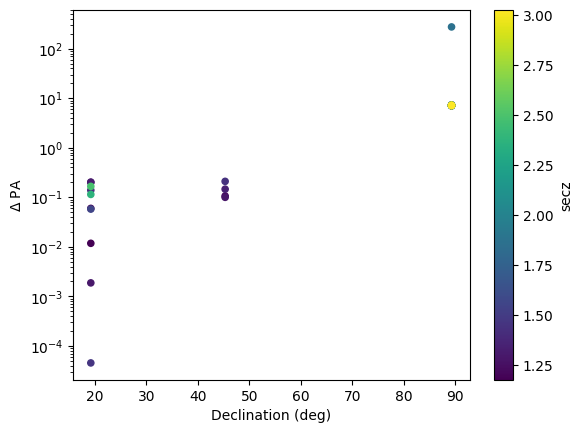

In [12]:
secz_ordered.plot.scatter(x='Decnum', y='dPA_RC_SC', c='secz')
plt.yscale('log')
plt.xlabel('Declination (deg)')
plt.ylabel(r'$\Delta$ PA');

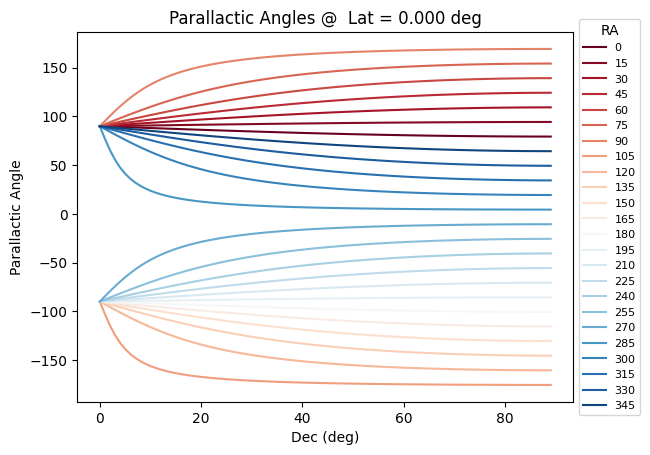

In [85]:
cmap = matplotlib.cm.RdBu

loc = EarthLocation(lat=0.0, lon=0.0, height=0.0)
obstime = Time('2022-01-01T00:00:00')
ras = np.arange(0,360,15)
decs = np.arange(0,90,1)
lmst = obstime.sidereal_time('mean', longitude=loc.lon).value
has = lmst - (ras / 15)

k=0
for ha, ra in zip(has, ras):
    pas = []
    for dec in decs:
        pas.append(celest_to_pa(ra, dec, obstime, loc))
    plt.plot(decs, pas, '-', color=cmap(k / float(len(ras))), label=ra)
    k += 1

plt.title('Parallactic Angles @  Lat = {0:.3f}'.format(loc.lat))
plt.xlabel('Dec (deg)')
plt.ylabel('Parallactic Angle')
plt.legend(title = 'RA', fontsize=8, bbox_to_anchor=(1.0, 1.05))

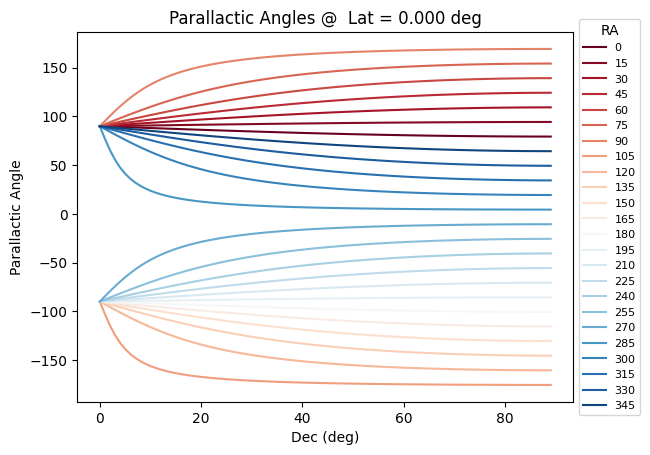

In [86]:
cmap = matplotlib.cm.RdBu

loc = EarthLocation(lat=0.0, lon=0.0, height=0.0)
obstime = Time('2022-01-01T00:00:00')
ras = np.arange(0,360,15)
decs = np.arange(0,90,1)
lmst = obstime.sidereal_time('mean', longitude=loc.lon).value
has = lmst - (ras / 15)

k=0
for ha, ra in zip(has, ras):

    pas = []
    for dec in decs:
        pas.append(Observer(location=loc).parallactic_angle(time=obstime, target = SkyCoord(ra=ra, dec=dec, unit=('deg'))).to(u.deg).value)

    plt.plot(decs, pas, '-', color=cmap(k / float(len(ras))), label=ra)
    k += 1

plt.title('Parallactic Angles @  Lat = {0:.3f}'.format(loc.lat))
plt.xlabel('Dec (deg)')
plt.ylabel('Parallactic Angle')
plt.legend(title = 'RA', fontsize=8, bbox_to_anchor=(1.0, 1.05))

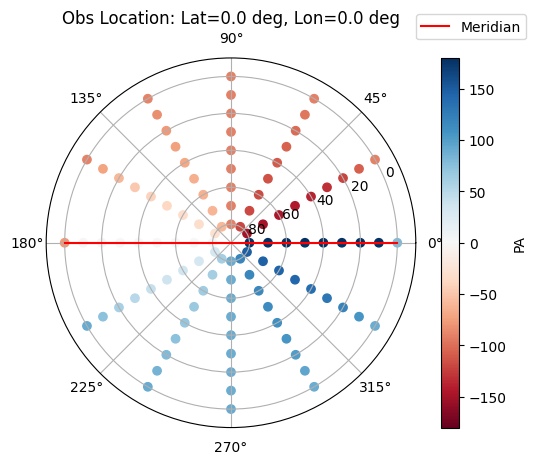

In [237]:
azs = np.arange(0,360,30) 
alts = np.arange(0,90,10)

az_arr = []
alt_arr = []

for az in azs:
    for alt in alts:
        az_arr.append(az)
        alt_arr.append(alt)
az_arr = np.array(az_arr)
alt_arr = np.array(alt_arr)

time = Time('2021-01-01T00:00:00')
loc = EarthLocation(lat=0, lon=0, height=0)

pas = []

for az in azs:
    for alt in alts:
        aa = SkyCoord(alt=alt, az=az, obstime=time, location=loc, unit=('deg'), frame='altaz')
        radec = aa.transform_to(ICRS)
        para_angle = celest_to_pa(ra = radec.ra.deg, dec = radec.dec.deg, time=time, loc=loc)
        pas.append(para_angle)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_rlim(90,-10)
a = ax.scatter(az_arr * deg2rad, alt_arr, c=pas, cmap='RdBu', clim=(-180,180))        
cbar = fig.colorbar(a)
cbar.set_label('PA')
plt.plot([0,np.pi],[0,0], c='red', label='Meridian')
plt.title('Obs Location: Lat={0}, Lon={1}'.format(loc.lat, loc.lon))
plt.legend(loc=(1.0,1.05))

## Astroplan

In [16]:
data.head()

,Observatory,UT Date,RA,Dec,Local Time,UT,LMST,HA,secz,PA,LMSTnum,RAnum,Decnum,PA_RC,dPA_RC_SC
0,Kitt Peak,2021-03-21,14 15 40,19 10 56,0:00:00,7:00:00,11:30:00,-2.783333,1.297,-62.6,11.500000,14.261111,19.182222,-62.598129,0.001871
1,Kitt Peak,2021-03-21,14 15 40,19 10 56,6:00:00,13:00:00,17:31:00,3.233333,1.42,63.5,17.516667,14.261111,19.182222,63.639142,0.139142
2,Kitt Peak,2021-03-21,2 41 39,89 15 51,0:00:00,7:00:00,11:30:00,8.333333,1.91,54.7,11.500000,2.694167,89.264167,47.575917,7.124083
3,Kitt Peak,2021-03-21,2 41 39,89 15 51,6:00:00,13:00:00,17:31:00,-9.65,1.918,-35.0,17.516667,2.694167,89.264167,-42.032424,7.032424
4,Kitt Peak,2021-09-23,14 15 40,19 10 56,0:00:00,7:00:00,23:43:00,9.433333,(down),36.3,23.716667,14.261111,19.182222,36.092179,0.207821


In [26]:
appa_arr = np.zeros(len(data))
ap_dpa = np.zeros(len(data))

for i in range(len(data)):
    obs = data.iloc[i]
    print(obs)
    print(' ')
    #Direct skycalc outputs
    loc = EarthLocation.of_site(obs['Observatory'])
    coord = SkyCoord(ra = obs['RAnum'], dec = obs['Decnum'], unit = (u.hourangle, u.deg))
    obstime = Time(obs['UT Date'] + 'T' + obs['UT'], scale='ut1')
    
    obsLMST = obs['LMSTnum']

    appa = Observer(location=loc).parallactic_angle(time=obstime, target=coord).to(u.deg).value
    appa_arr[i] = appa
    ap_dpa[i] = np.abs(appa - obs['PA'])

    #PA
    print('Astroplan says: PA = {}'.format(appa))
    print('Skycalc says: PA = {}'.format(obs['PA']))
    print(' ')

data['PA_AP'] = appa_arr

Observatory     Kitt Peak
UT Date        2021-03-21
RA               14 15 40
Dec              19 10 56
Local Time        0:00:00
UT                7:00:00
LMST             11:30:00
HA              -2.783333
secz                1.297
PA                  -62.6
LMSTnum              11.5
RAnum           14.261111
Decnum          19.182222
PA_RC          -62.598129
dPA_RC_SC        0.001871
PA_AP          -62.613923
dPA_AP_SC        0.013923
dPA_AP_RC        0.015794
Name: 0, dtype: object
 
Astroplan says: PA = -62.6139226525333
Skycalc says: PA = -62.6
 
Observatory     Kitt Peak
UT Date        2021-03-21
RA               14 15 40
Dec              19 10 56
Local Time        6:00:00
UT               13:00:00
LMST             17:31:00
HA               3.233333
secz                 1.42
PA                   63.5
LMSTnum         17.516667
RAnum           14.261111
Decnum          19.182222
PA_RC           63.639142
dPA_RC_SC        0.139142
PA_AP           63.632268
dPA_AP_SC        0.132268

In [27]:
data['dPA_AP_SC'] = np.abs(data['PA'] - data['PA_AP'])

In [28]:
data['dPA_AP_RC'] = np.abs(data['PA_RC'] - data['PA_AP'])

In [29]:
data.head()

,Observatory,UT Date,RA,Dec,Local Time,UT,LMST,HA,secz,PA,LMSTnum,RAnum,Decnum,PA_RC,dPA_RC_SC,PA_AP,dPA_AP_SC,dPA_AP_RC
0,Kitt Peak,2021-03-21,14 15 40,19 10 56,0:00:00,7:00:00,11:30:00,-2.783333,1.297,-62.6,11.500000,14.261111,19.182222,-62.598129,0.001871,-62.613923,0.013923,0.015794
1,Kitt Peak,2021-03-21,14 15 40,19 10 56,6:00:00,13:00:00,17:31:00,3.233333,1.42,63.5,17.516667,14.261111,19.182222,63.639142,0.139142,63.632268,0.132268,0.006874
2,Kitt Peak,2021-03-21,2 41 39,89 15 51,0:00:00,7:00:00,11:30:00,8.333333,1.91,54.7,11.500000,2.694167,89.264167,47.575917,7.124083,47.653130,7.046870,0.077213
3,Kitt Peak,2021-03-21,2 41 39,89 15 51,6:00:00,13:00:00,17:31:00,-9.65,1.918,-35.0,17.516667,2.694167,89.264167,-42.032424,7.032424,-41.951686,6.951686,0.080739
4,Kitt Peak,2021-09-23,14 15 40,19 10 56,0:00:00,7:00:00,23:43:00,9.433333,(down),36.3,23.716667,14.261111,19.182222,36.092179,0.207821,36.090179,0.209821,0.002000


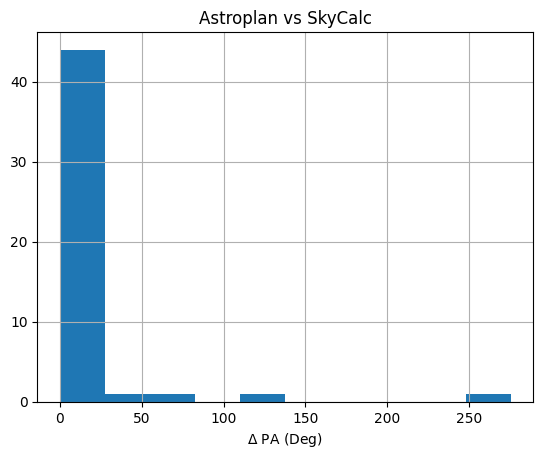

In [89]:
data['dPA_AP_SC'].hist()
plt.title('Astroplan vs SkyCalc')
plt.xlabel(r'$\Delta$ PA (Deg)');

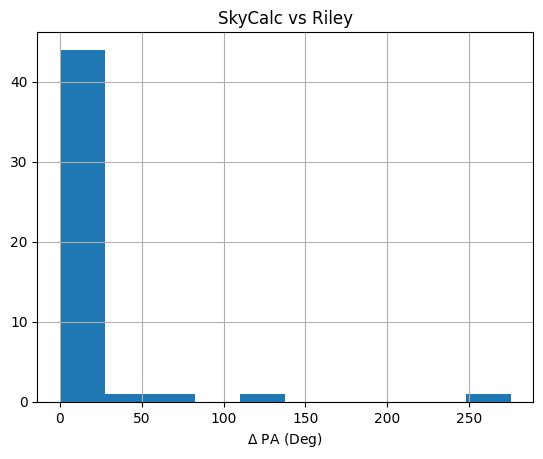

In [91]:
data['dPA_RC_SC'].hist()
plt.title('SkyCalc vs Riley')
plt.xlabel(r'$\Delta$ PA (Deg)');

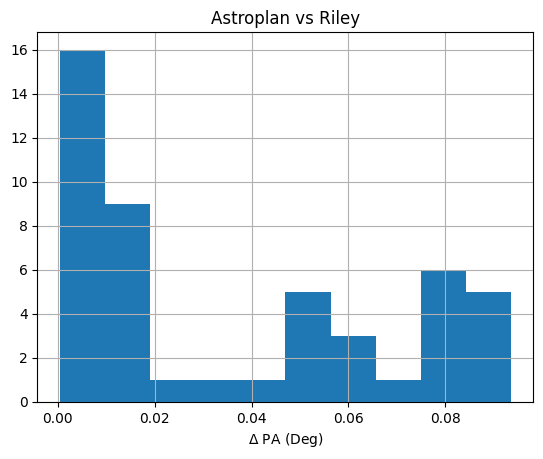

In [88]:
data['dPA_AP_RC'].hist()
plt.title('Astroplan vs Riley')
plt.xlabel(r'$\Delta$ PA (Deg)');

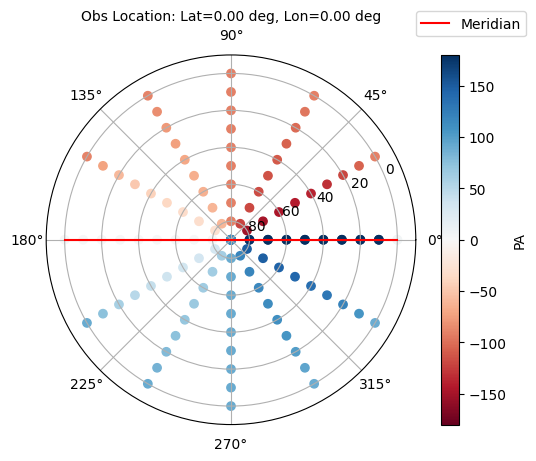

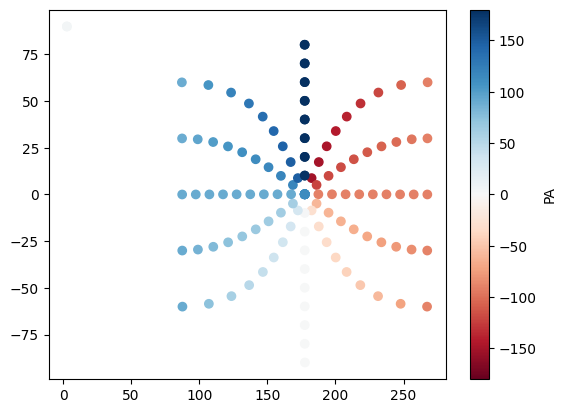

In [281]:
azs = np.arange(0,390,30) 
alts = np.arange(0,100,10)

az_arr = []
alt_arr = []

time = Time('2021-03-20T00:00:00')
loc = EarthLocation(lat=0, lon=0, height=0)
obs = Observer(location=loc)

pas = []
ra_arr = []
dec_arr = []

for az in azs:
    for alt in alts:
        az_arr.append(az)
        alt_arr.append(alt)
        aa = SkyCoord(alt=alt, az=az, obstime=time, location=loc, unit=('deg'), frame='altaz')
        radec = aa.transform_to(ICRS)
        ra_arr.append(radec.ra.deg)
        dec_arr.append(radec.dec.deg)
        para_angle = obs.parallactic_angle(time=time, target=radec).to(u.deg).value
        para_angle = celest_to_pa(ra = radec.ra.deg, dec = radec.dec.deg, time=time, loc=loc)
        pas.append(para_angle)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_rlim(90,-10)
a = ax.scatter(np.array(az_arr) * deg2rad, np.array(alt_arr), c=pas, cmap='RdBu', clim=(-180,180))        
cbar = fig.colorbar(a)
cbar.set_label('PA')
plt.plot([0,np.pi],[0,0], c='red', label='Meridian')
plt.title('Obs Location: Lat={0:.2f}, Lon={1:.2f}'.format(loc.lat, loc.lon), fontsize=10)
plt.legend(loc=(1.0,1.05))

fig, ax = plt.subplots()
a = ax.scatter(ra_arr, dec_arr, c=pas, cmap='RdBu', clim=(-180,180))        
cbar = fig.colorbar(a)
cbar.set_label('PA')

In [275]:
EarthLocation.get_site_names()

['ALMA',
 'AO',
 'ARCA',
 'ASKAP',
 'ATST',
 'Anderson Mesa',
 'Anglo-Australian Observatory',
 'Apache Point',
 'Apache Point Observatory',
 'Arecibo',
 'Arecibo Observatory',
 'Astroparticle Research with Cosmics in the Abyss',
 'Atacama Large Millimeter Array',
 'Australian Square Kilometre Array Pathfinder',
 'BAO',
 'BBSO',
 'Beijing XingLong Observatory',
 'Big Bear Solar Observatory',
 'Black Moshannon Observatory',
 'CAHA',
 'CAHA',
 'CHARA',
 'CHIME',
 'Canada-France-Hawaii Telescope',
 'Canadian Hydrogen Intensity Mapping Experiment',
 'Catalina Observatory',
 'Catalina Observatory: 61 inch telescope',
 'Centro Astronomico Hispano-Aleman, Almeria',
 'Cerro Pachon',
 'Cerro Paranal',
 'Cerro Tololo',
 'Cerro Tololo Interamerican Observatory',
 'Cima Ekar 182 cm Telescope',
 'Cima Ekar Observing Station',
 'DCT',
 'DKIST',
 'DRAO',
 'DRAO 26m Telescope',
 'Daniel K. Inouye Solar Telescope',
 'Discovery Channel Telescope',
 'Dominion Astrophysical Observatory',
 'Dominion Radio 

In [287]:
aa = SkyCoord(alt=30, az=270, obstime=time, location=loc, unit=('deg'), frame='altaz')
radec = aa.transform_to(ICRS)
print('RA = ' + str(radec.ra.deg))
print('Dec = ' + str(radec.dec.deg))
print('astroplan PA = ' + str(Observer(location=loc).parallactic_angle(time=time, target=radec).to(u.deg).value))
print('my PA = ' + str(celest_to_pa(radec.ra.deg, radec.dec.deg, time, loc)))

RA = 117.47405903467343
Dec = 0.055523760300334804
astroplan PA = 90.03170299185948
my PA = 90.03170299185948
